### This version builds on top of stochastic model but takes the Stedin network as an input. Run classical nonlinear power flow equations wihth ipopt
* no trafo limits
* no line loading limits
* no voltage limits (still present but relaxed)
* fixed load and generation

##### The robustness is set to neutral (50%) - realized generation is set to the expectation

In [1]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import beta, weibull_min
from scipy.special import gamma

plt.style.use({'figure.facecolor':'white'})

In [2]:
def read_input(filename):
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand', index_col=0, usecols='B:AS')
    PVData = pd.read_excel(filename, sheet_name='PVData')
    PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
    WindData = pd.read_excel(filename, sheet_name='WindData')
    WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')
    Storage = pd.read_excel(filename, sheet_name='Storages')
    LineData = pd.read_excel(filename, sheet_name='LineData')
    CableTypes = pd.read_excel(filename, sheet_name='CableTypes')
    DGs = pd.read_excel(filename, sheet_name='DGs')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'PVData':PVData, 'PVGeneration':PVGeneration, \
            'WindData':WindData, 'WindGeneration':WindGeneration, 'Storage':Storage,  'LineData':LineData, \
            'CableTypes':CableTypes, 'DGs':DGs}

In [3]:

def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, eta_conf):

    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------

    LineData = inputData['LineData']
    CableTypes = inputData['CableTypes']
    SystemDemand = inputData['SystemDemand']
    PVData = inputData['PVData']
    PVGeneration = inputData['PVGeneration']
    WindData = inputData['WindData']
    WindGeneration = inputData['WindGeneration']
    StorageData = inputData['Storage']
    NodeData = inputData['NodeData']
    DGData = inputData['DGs']

    time = [i for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    pvs = [PVData.loc[i,'NODES'] for i in PVData.index]
    wts = [WindData.loc[i,'NODES'] for i in WindData.index]
    storages = [StorageData.loc[i,'NODES'] for i in StorageData.index]
    DGs = [DGData.loc[i,'NODES'] for i in DGData.index]

    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'R'].iloc[0] for i in LineData.index}    # ohm
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'X'].iloc[0] for i in LineData.index}    # ohm
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'D']*CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'B'].iloc[0] for i in LineData.index}    # uS
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}

    Pd = {(k, i): SystemDemand.loc[i, k]*1000/Sbase for k in SystemDemand.columns for i in SystemDemand.index}  # kW
    Qd = {(k, i): SystemDemand.loc[i, k]*np.tan(np.arccos(0.98)*1000/Sbase) for k in SystemDemand.columns for i in SystemDemand.index}  # kVAr
    Ss_max = {buses[i]: NodeData.loc[i, 'Smax']/Sbase for i in NodeData.index}      # kVA
    I_max = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']):CableTypes.loc[CableTypes['TYPE'] == LineData.loc[i,'TYPE'],'IRATED'].iloc[0]/Ibase for i in LineData.index} # p.u.

    # random variables for renewables
    mu_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'mean'] for t in PVGeneration.index for i in PVData.index}
    var_st = {(pvs[i], time[t]):PVGeneration.loc[t, 'variance'] for t in PVGeneration.index for i in PVData.index}
    mu_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'mean'] for t in WindGeneration.index for i in WindData.index}
    var_wt = {(wts[i], time[t]):WindGeneration.loc[t, 'variance'] for t in WindGeneration.index for i in WindData.index}

    Ppvpp = {pvs[i]:PVData.loc[i, 'PPV']/Sbase for i in PVData.index}
    #Q is stil taken from the input - 0 (does not consider irradiation - assumes unity power factor)
    Qpv = {(pvs[i], time[k]):PVData.loc[i, 'QPV']*PVGeneration.loc[k, 'QPV']/Sbase for k in PVGeneration.index for i in PVData.index}   #kW -> p.u.

    Pwpp = {wts[i]:WindData.loc[i, 'PWT']/Sbase for i in WindData.index}
    #Q is stil taken from the input - 0 (does not consider wind speed - assumes unity power factor)
    Qwt = {(wts[i], time[k]):WindData.loc[i, 'QWT']*WindGeneration.loc[k, 'QWT']/Sbase for k in WindGeneration.index for i in WindData.index}   #kW -> p.u.
    wsin = 3                #Cut-in wind speed in (m/s)
    wsr = 12                #Rated wind speed in (m/s)
    wsout = 20              #Cut-off wind speed in (m/s)

    ESS_Pmax = {storages[i]:StorageData.loc[i, 'Power']/Sbase for i in StorageData.index} #p.u.
    ESS_SOCmax = {storages[i]:StorageData.loc[i, 'Energy']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_SOCmin = {storages[i]:0 for i in StorageData.index} #%
    ESS_SOCini = {storages[i]:StorageData.loc[i, 'SOEini']/StorageData.loc[i, 'Energy']*100 for i in StorageData.index} #%
    ESS_Eff = {storages[i]:StorageData.loc[i, 'Eff'] for i in StorageData.index}
    ESS_SOEmax = {storages[i]:StorageData.loc[i, 'Energy'] for i in StorageData.index} #kWh

    DG_FC = {DGs[i]:DGData.loc[i, 'FC'] for i in DGData.index}             #m^3
    DG_H = {DGs[i]:DGData.loc[i, 'H']/Sbase for i in DGData.index}         #kWh/m^3 -> pu
    DG_Eff = {DGs[i]:DGData.loc[i, 'eff'] for i in DGData.index}           #%
    DG_pf = {DGs[i]:DGData.loc[i, 'pf'] for i in DGData.index}
    DG_Rup = {DGs[i]:DGData.loc[i, 'Rup']/Sbase for i in DGData.index}     #kW/h -> pu
    DG_Rdw = {DGs[i]:DGData.loc[i, 'Rdw']/Sbase for i in DGData.index}     #kW/h -> pu
    DG_Smax = {DGs[i]:DGData.loc[i, 'Smax']/Sbase for i in DGData.index}   #kW -> pu

    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    model.LINES = Set(initialize=lines)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)
    model.PV = Set(initialize=pvs)
    model.WT = Set(initialize=wts)
    model.EES = Set(initialize=storages)
    model.DG = Set(initialize=DGs)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)   # ohm
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)   # ohm
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)   # uS
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.
    model.Ss_max = Param(model.NODES, initialize=Ss_max, mutable=True, within=Any)  # p.u.
    model.I_max = Param(model.LINES, initialize=I_max, mutable=True, within=NonNegativeReals)   # p.u.

    #Load
    model.Pd = Param(model.NODES, model.TIME, initialize=Pd, mutable=True, within=Any)
    model.Qd = Param(model.NODES, model.TIME, initialize=Qd, mutable=True, within=Any)
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)

    #PV generation
    model.Ppvpp = Param(model.PV, initialize=Ppvpp)
    model.Qpv = Param(model.PV, model.TIME, initialize=Qpv, mutable=True, within=Any)       #pu
    model.mu_st = Param(model.PV, model.TIME, initialize=mu_st, mutable=True, within=Any)
    model.var_st = Param(model.PV, model.TIME, initialize=var_st, mutable=True, within=Any)

    #Wind generation
    model.Pwpp = Param(model.WT, initialize=Pwpp)
    model.Qwt = Param(model.WT, model.TIME, initialize=Qwt, mutable=True, within=Any)       #pu
    model.mu_wt = Param(model.WT, model.TIME, initialize=mu_wt, mutable=True, within=Any)
    model.var_wt = Param(model.WT, model.TIME, initialize=var_wt, mutable=True, within=Any)
    model.wsin = Param(initialize=wsin)                 #Cut-in wind speed in (m/s)
    model.wsr = Param(initialize=wsr)                   #Rated wind speed in (m/s)
    model.wsout = Param(initialize=wsout)               #Cut-off wind speed in (m/s)

    #Random variable confidence
    model.eta_conf = Param(initialize=eta_conf)

    #Energy storage system
    model.ESS_Pmax = Param(model.EES, initialize=ESS_Pmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmax = Param(model.EES, initialize=ESS_SOCmax, within=NonNegativeReals, mutable=True)
    model.ESS_SOCmin = Param(model.EES, initialize=ESS_SOCmin, within=NonNegativeReals, mutable=True)
    model.ESS_SOCini = Param(model.EES, initialize=ESS_SOCini, within=NonNegativeReals, mutable=True)
    model.ESS_Eff = Param(model.EES, initialize=ESS_Eff, within=NonNegativeReals, mutable=True)
    model.ESS_SOEmax = Param(model.EES, initialize=ESS_SOEmax, within=NonNegativeReals, mutable=True)

    #Distributed Generation
    model.DG_FC = Param(model.DG, initialize=DG_FC, within=NonNegativeReals, mutable=True)
    model.DG_H = Param(model.DG, initialize=DG_H, within=NonNegativeReals, mutable=True)
    model.DG_Eff = Param(model.DG, initialize=DG_Eff, within=NonNegativeReals, mutable=True)
    model.DG_pf = Param(model.DG, initialize=DG_pf, within=NonNegativeReals, mutable=True)
    model.DG_Rup = Param(model.DG, initialize=DG_Rup, within=NonNegativeReals, mutable=True)
    model.DG_Rdw = Param(model.DG, initialize=DG_Rdw, within=NonPositiveReals, mutable=True)
    model.DG_Smax = Param(model.DG, initialize=DG_Smax, within=NonNegativeReals, mutable=True)

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]*1E-6/Zbase
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    #Random variables
    def pv_active_power(model, pv, t):
        if mu_st[pv,t] == 0:
            return 0
        else:
            b = (1 - mu_st[pv,t])*(mu_st[pv,t]*(1 + mu_st[pv,t])/var_st[pv,t] - 1)
            a = mu_st[pv,t]*b/(1 - mu_st[pv,t])
            irrad = beta.ppf(1 - eta_conf, a, b)
            return model.Ppvpp[pv]*irrad
    model.Ppv = Param(model.PV, model.TIME, rule=pv_active_power)

    def wt_active_power(model, wt, t):
        kappa = (np.sqrt(var_wt[wt,t])/mu_wt[wt,t])**(-1.086)
        lambd = mu_wt[wt,t]/gamma(1 + 1/kappa)
        wind = weibull_min.ppf(1 - eta_conf, kappa, scale=lambd)

        if wind < wsin:
            return 0
        elif wsin < wind < wsr:
            return model.Pwpp[wt]*(wind**3 - model.wsin**3)/(model.wsr**3 - model.wsin**3)
        elif model.wsr < wind < model.wsout:
            return model.Pwpp[wt]
        elif wind[t] > wsout:
            return 0
    model.Pwt = Param(model.WT, model.TIME, rule=wt_active_power)

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    #Network
    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #Energy storage system
    model.Pch = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.Pdis = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=0)
    model.u_ess = Var(model.EES, model.TIME, within=Binary)

    def initial_SOC_rule(model, s, t):
        return model.ESS_SOCini[s].value
    model.SOC = Var(model.EES, model.TIME, within=NonNegativeReals, initialize=initial_SOC_rule)

    #Supply
    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule)

    #Distributed generation
    model.Pdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=0)
    model.Qdg = Var(model.DG, model.TIME, within=NonNegativeReals, initialize=0)
    model.Fdg = Var(model.DG, model.TIME, within=NonNegativeReals)
    model.u_dg = Var(model.DG, model.TIME, within=Binary)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def act_loss(model):
        return sum(model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    #Power balance
    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind + Power_discharged = Power_out + Power_out_lost + Power_consumed + Power_charged
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + \
               sum(model.Pwt[w,t] for w in model.WT if w==k) + sum(model.Pdis[s,t] for s in model.EES if s == k) + sum(model.Pdg[g,t] for g in model.DG if g == k) == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]) for i,j in model.LINES if i == k) + model.Pd[k,t] + sum(model.Pch[s,t] for s in model.EES if s == k)
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied + Power_pv + Power_wind = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t])*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] + sum(model.Qpv[p,t] for p in model.PV if p == k) + \
               sum(model.Qwt[w,t] for w in model.WT if w == k) + sum(model.Qdg[g,t] for g in model.DG if g == k) == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]) - (model.V[i,t])*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    # Network constraints
    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]) - (model.V[j,t]) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t] == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)

    def define_current_rule(model, i, j, t):
        return (model.V[j,t])*(model.I[i,j,t]) == (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
    model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

    def voltage_limit_rule(model, n, t):
        return inequality(model.Vmin**2, model.V[n,t], model.Vmax**2)
    model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    def current_limit_rule(model, i, j, t):
        return 0 <= model.I[i,j,t]
        #return inequality(0, model.I[i,j,t], (3*model.I_max[i,j])**2)
    model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

    # Substation limits
    def subst_capacity_limit_rule(model, k, t):
       return  (model.Ps[k,t] - model.Pd[k,t] + sum(model.Ppv[p,t] for p in model.PV if p==k) + sum(model.Pwt[w,t] for w in model.WT if w==k) - \
                 sum(model.Pdis[s,t] - model.Pch[s,t] for s in model.EES if s == k) + sum(model.Qdg[g,t] for g in model.DG if g == k))**2 + \
                (model.Qs[k,t] - model.Qd[k,t] + sum(model.Qpv[p,t] for p in model.PV if p==k) + sum(model.Qwt[w,t] for w in model.WT if w==k))**2 <= \
                model.Ss_max[k]**2
    # model.subst_capacity_limit = Constraint(model.NODES, model.TIME, rule=subst_capacity_limit_rule)

    # Storage constraints
    def ESS_SOCupdate_rule(model, s, t):
        if model.TIME.ord(t) == 1:
            return model.SOC[s,t] == model.ESS_SOCini[s] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
        if model.TIME.ord(t) > 1:
            return model.SOC[s,t] == model.SOC[s,model.TIME.prev(t)] + 100/model.ESS_SOEmax[s]*(model.ESS_Eff[s]*model.Pch[s,t]*Sbase - model.Pdis[s,t]*Sbase/model.ESS_Eff[s])
    model.EES_SOCupdate = Constraint(model.EES, model.TIME, rule=ESS_SOCupdate_rule)

    def ESS_SOClimit_rule(model, s, t):
        return inequality(model.ESS_SOCmin[s], model.SOC[s,t], model.ESS_SOCmax[s])
    model.ESS_SOClimit = Constraint(model.EES, model.TIME, rule=ESS_SOClimit_rule)

    def ESS_Charging_rule(model, s, t):
        return model.Pch[s,t] <= model.ESS_Pmax[s]*model.u_ess[s,t]
    model.ESS_Charging = Constraint(model.EES, model.TIME, rule=ESS_Charging_rule)

    def ESS_Discharging_rule(model, s, t):
        return model.Pdis[s,t] <= model.ESS_Pmax[s]*(1-model.u_ess[s,t])
    model.ESS_Discharging = Constraint(model.EES, model.TIME, rule=ESS_Discharging_rule)

    #Distributed generation constraints
    def dg_capacity_limit_rule(model, g, t):
        return (model.Pdg[g,t])**2 + (model.Qdg[g,t])**2 <= model.u_dg[g,t]*(model.DG_Smax[g])**2
    model.dg_capacity_limit = Constraint(model.DG, model.TIME, rule=dg_capacity_limit_rule)

    def dg_powerfactor_cap_rule(model, g, t):
        return model.Pdg[g,t]*tan(acos(model.DG_pf[g])) >= model.Qdg[g,t]
    model.dg_powerfactor_cap = Constraint(model.DG, model.TIME, rule=dg_powerfactor_cap_rule)

    def dg_powerfactor_ind_rule(model, g, t):
        return -model.Pdg[g,t]*tan(acos(model.DG_pf[g])) <= model.Qdg[g,t]
    model.dg_powerfactor_ind = Constraint(model.DG, model.TIME, rule=dg_powerfactor_ind_rule)

    def dg_ramp_up_down_rule(model, g, t):
        if model.TIME.ord(t) == 1:
            # the DG is initially off
            return inequality(model.DG_Rdw[g], model.Pdg[g,t] - 0, model.DG_Rup[g])
        if model.TIME.ord(t) > 1:
            return inequality(model.DG_Rdw[g], model.Pdg[g,t] - model.Pdg[g,model.TIME.prev(t)], model.DG_Rup[g])
    model.dg_ramp_up_down = Constraint(model.DG, model.TIME, rule=dg_ramp_up_down_rule)

    def dg_fuel_rule(model, g, t):
        if model.TIME.ord(t) == 1:
            # set arbitrary initial amount of fuel (800 cubic meters)
            return model.Fdg[g,t] == 300 - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
        if model.TIME.ord(t) > 1:
            return model.Fdg[g,t] == model.Fdg[g,model.TIME.prev(t)] - model.Pdg[g,t]/(model.DG_Eff[g]/100*model.DG_FC[g]*model.DG_H[g])
    model.dg_fuel = Constraint(model.DG, model.TIME, rule=dg_fuel_rule)

    def dg_min_fuel_rule(model, g, t):
        return model.Fdg[g,t] >= 0
    model.dg_min_fuel = Constraint(model.DG, model.TIME, rule=dg_min_fuel_rule)


    return model, buses, lines, pvs, wts, storages, DGs

In [4]:
data = read_input(r'Input_Files\InputDataVreeswajk_v1.xlsx')
Sbase = 1000 # kVA
Vnom = 10/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Ibase = Sbase/Vnom/1000 # kA
Vmax = 1.5
Vmin = 0.5
eta_conf = 5/100
model, buses, lines, pvs, wts, storages, DGs = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase, Ibase, eta_conf)
#model.pprint()

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [5]:
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   111216
Number of nonzeros in inequality constraint Jacobian.:    14112
Number of nonzeros in Lagrangian Hessian.............:    20664

Total number of variables............................:    28560
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 42840, 'Number of variables': 28560, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 2.5007882118225098}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [6]:
# CHECK LOSSES+DEMAND=SUPPLY
losses = value(model.obj)
supply = sum(sum(value(model.Pdg[g,t]) for g in model.DG if g) + sum(value(model.Ps[n, t]) for n in model.NODES) + sum(value(model.Ppv[p, t]) for p in model.PV) + sum(value(model.Pwt[w,t]) for w in model.WT) + sum(value(model.Pdis[s, t]) for s in model.EES) for t in model.TIME)
demand = sum(sum(value(model.Pd[n, t]) for n in model.NODES) + sum(value(model.Pch[s, t]) for s in model.EES) for t in model.TIME)
print([supply, demand, losses])
print([supply*Sbase, demand*Sbase, losses*Sbase, demand*Sbase + losses*Sbase])

[334.423902594485, 328.1446, 6.279302594484901]
[334423.90259448503, 328144.60000000003, 6279.3025944849005, 334423.9025944849]


In [7]:
# DATA VISUALIZATION

loading = pd.DataFrame(columns=lines, index=data['SystemDemand'].index)
voltage = pd.DataFrame(columns=buses, index=data['SystemDemand'].index)
active_s = pd.DataFrame(columns=buses[0:1], index=data['SystemDemand'].index)
reactive_s = pd.DataFrame(columns=buses[0:1], index=data['SystemDemand'].index)
apparent_s = pd.DataFrame(columns=buses[0:1], index=data['SystemDemand'].index)

for t in model.TIME:
    for n in model.NODES:
        voltage.loc[t,n] = np.sqrt(model.V[n,t].value)
        if n == 8284:
            active_s.loc[t,n] = model.Ps[n,t].value*Sbase
            reactive_s.loc[t,n] = model.Qs[n,t].value*Sbase
            apparent_s.loc[t,n] = np.sqrt(active_s.loc[t,n]**2 + reactive_s.loc[t,n]**2)

for i,j in model.LINES:
    for t in model.TIME:
        loading.loc[t, pd.IndexSlice[i, j]] = np.sqrt(model.I[i,j,t].value)/(3*model.I_max[i,j].value)*100

Ss_max = model.Ss_max[8284].value*Sbase
pd.set_option('display.max_columns', None)

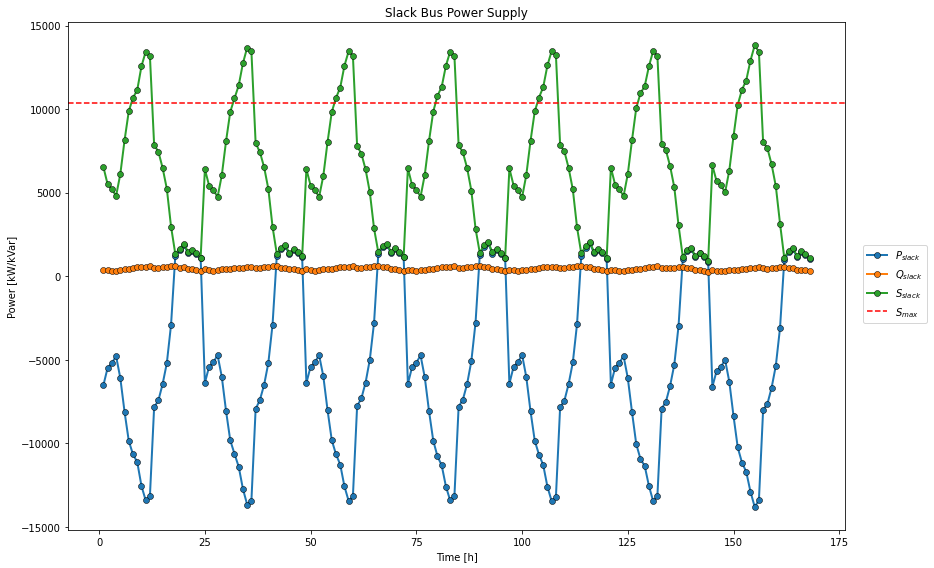

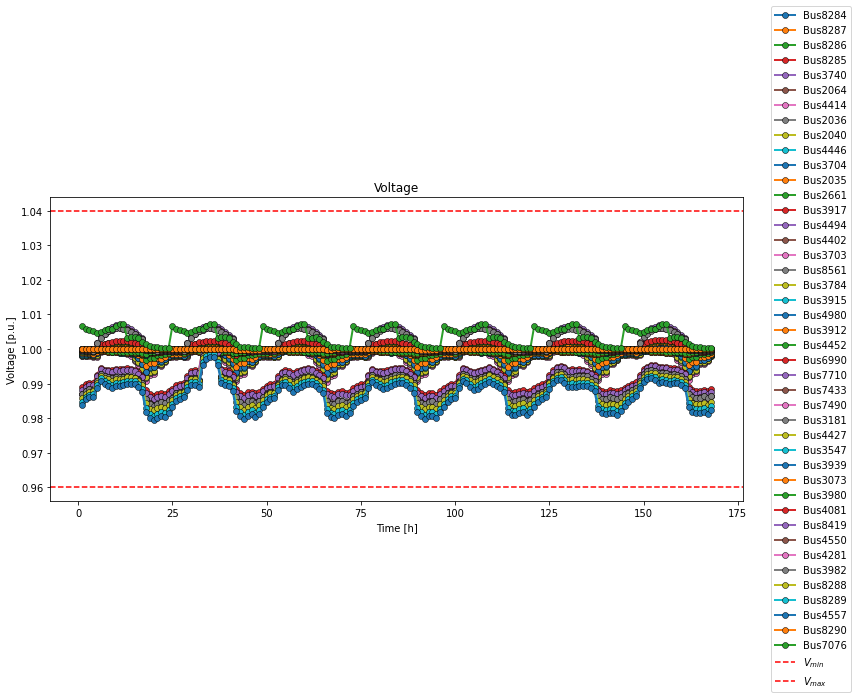

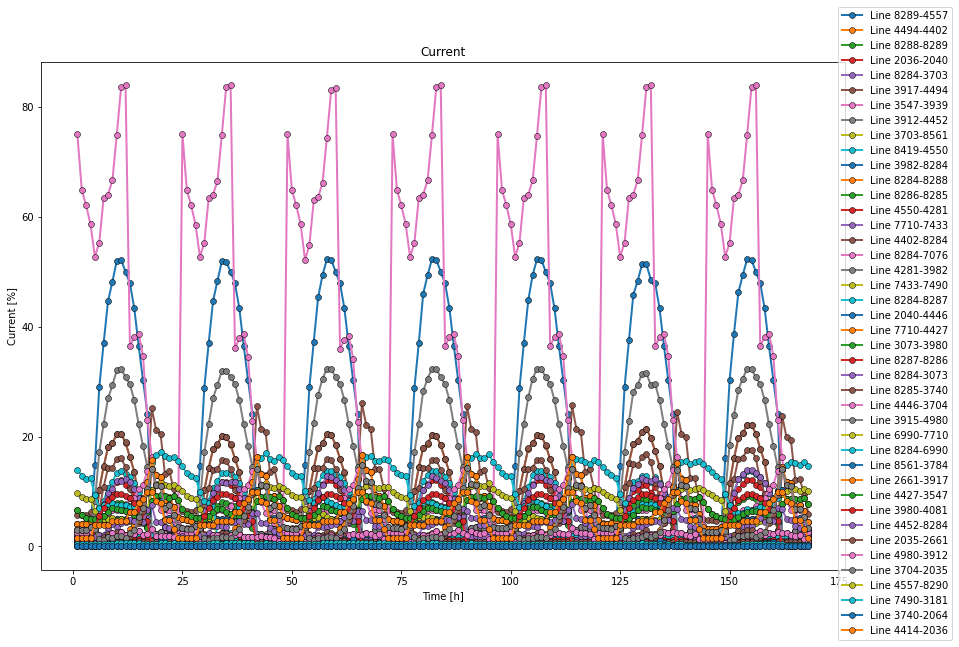

In [8]:
# Active and reactive power demand and supply (supply only from from slack bus)
fig_pow, ax_pow = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_pow[0,0].plot(active_s.index, active_s, marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5, label = '$P_{slack}$');ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Power [kW/kVar]');ax_pow[0,0].set_title('Slack Bus Power Supply');
ax_pow[0,0].plot(reactive_s.index, reactive_s, marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5, label = '$Q_{slack}$')
ax_pow[0,0].plot(reactive_s.index, apparent_s, marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5, label='$S_{slack}$')
ax_pow[0,0].axhline(Ss_max, color='r', linestyle='--', label='$S_{max}$')
fig_pow.legend(bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pow.tight_layout()
fig_pow.show;
plt.savefig('power.png', bbox_inches='tight')


# Voltage profile
b=['Bus'+str(i) for i in voltage.columns]
b.extend({'$V_{min}$','$V_{max}$'})
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_v[0,0].plot(voltage.index, voltage.loc[:,:], marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5);ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
ax_v[0,0].axhline(1.04, color='r', linestyle='--')
ax_v[0,0].axhline(0.96, color='r', linestyle='--')
ax_v[0,0].legend(b, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig_v.tight_layout()
fig_v.show;
plt.savefig('voltage.png', bbox_inches='tight')

# Current profile
fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_i[0,0].plot(loading.index, loading, marker='o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5);ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [%]');ax_i[0,0].set_title('Current');
fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_i.tight_layout()
fig_i.show;
plt.savefig('current.png', bbox_inches='tight')

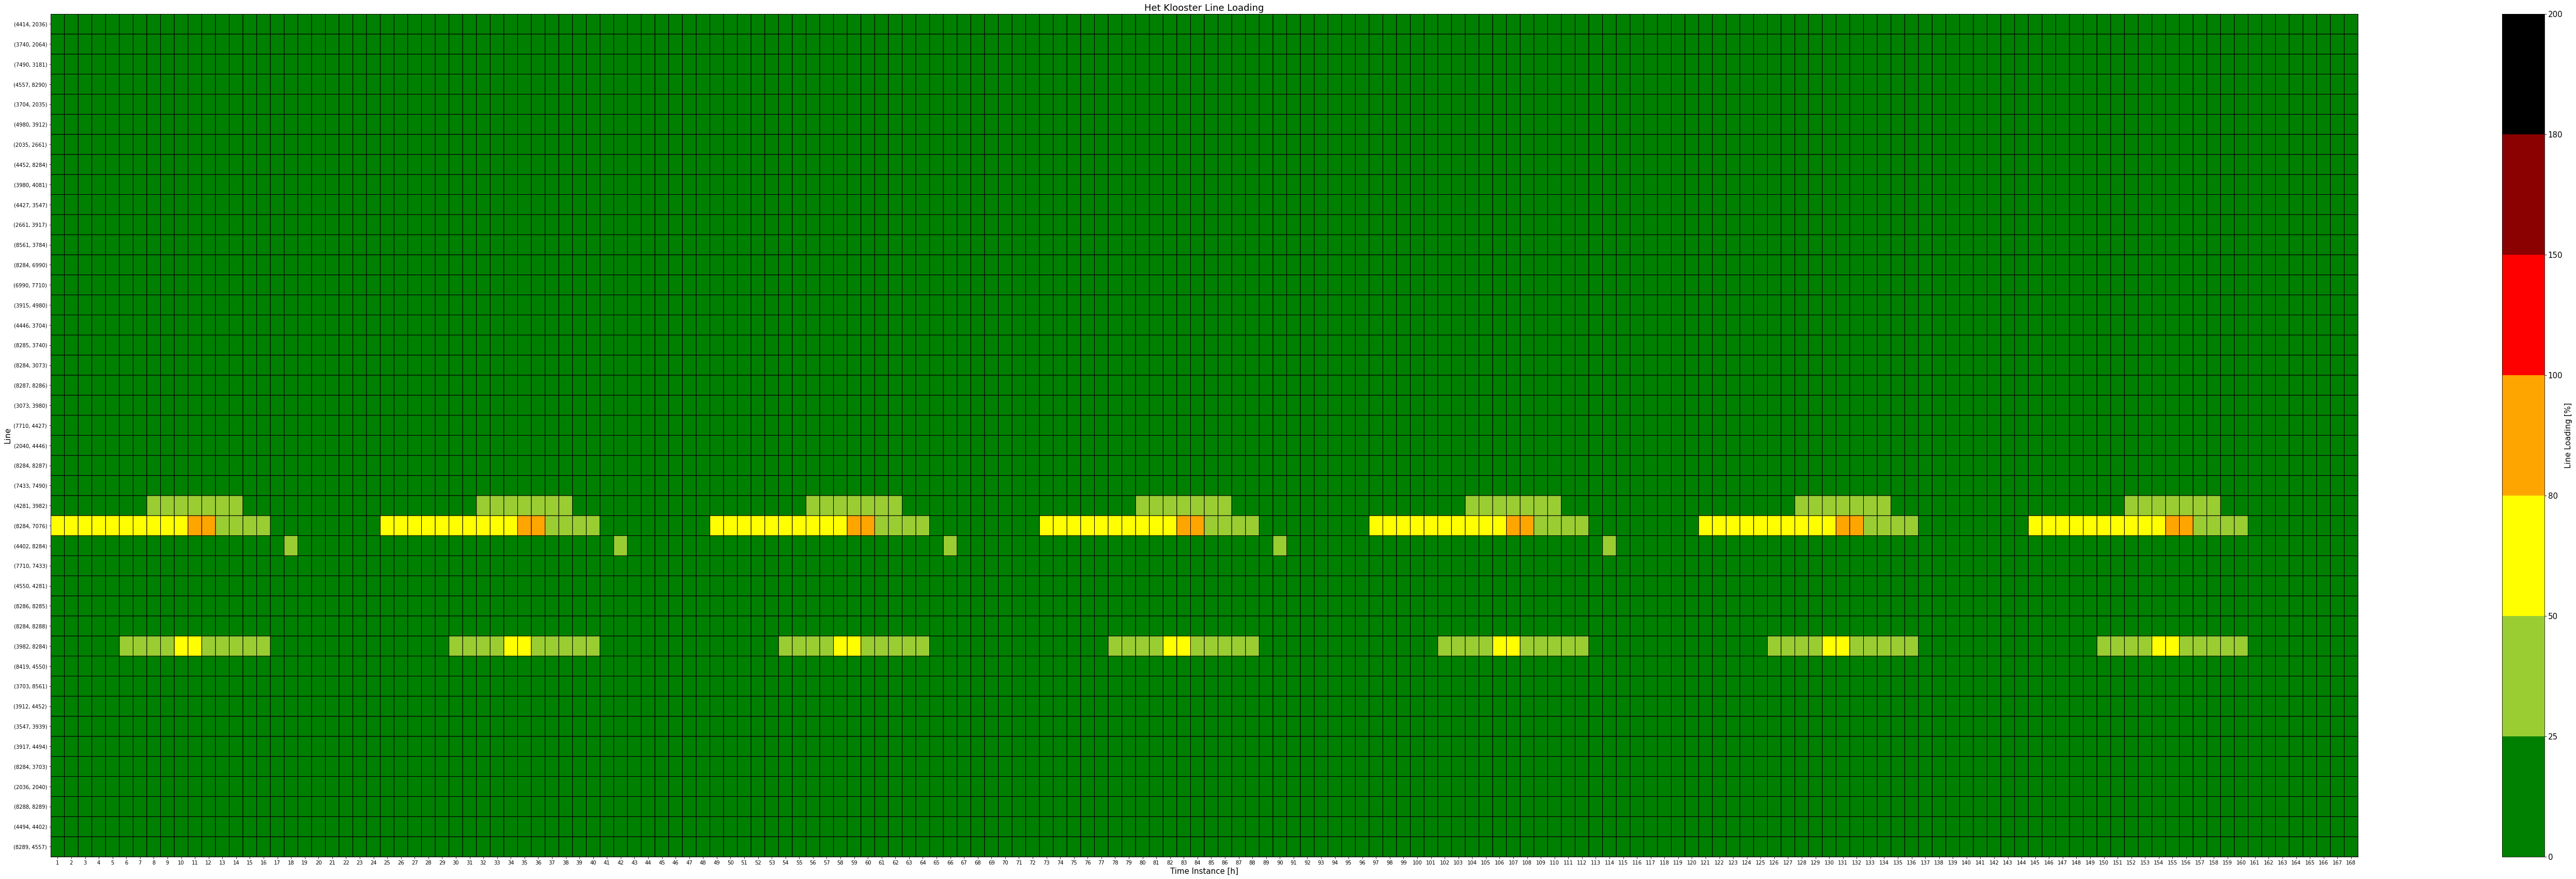

In [9]:
plt.figure(figsize=(100,30))
cmap, norm = mcolors.from_levels_and_colors([0, 25, 50, 80, 100.01, 150, 180, 200], ['green', 'yellowgreen', 'yellow', 'orange','red', 'darkred','black'])
plt.pcolor(loading.T, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
plt.xticks(np.arange(0.5, len(loading.index), 1), loading.index)
plt.yticks(np.arange(0.5, len(loading.columns), 1), loading.columns)
plt.title("Het Klooster Line Loading",fontsize=18)
plt.xlabel("Time Instance [h]",fontsize=15)
cb = plt.colorbar()
cb.set_label("Line Loading [%]",fontsize=15)
plt.ylabel("Line",fontsize=15)
cb.ax.tick_params(labelsize=15)
plt.savefig('loading_week.png', bbox_inches='tight')
plt.show()

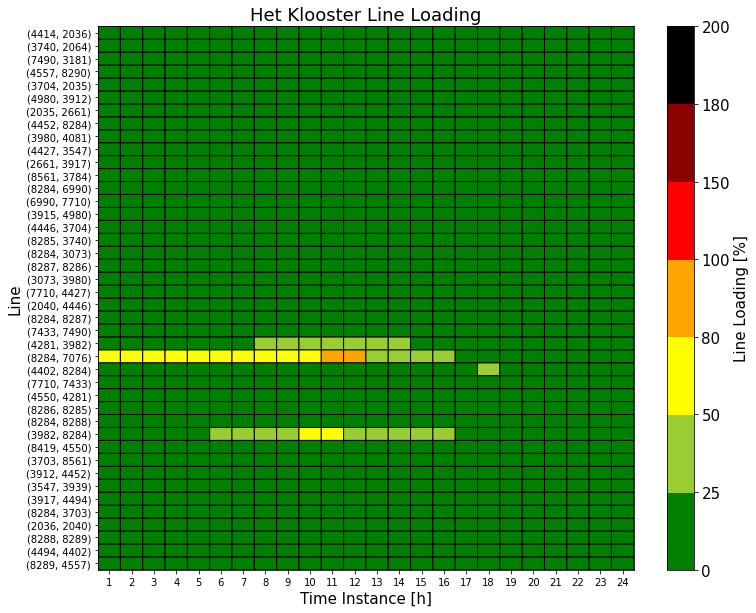

      8284    8287    8286    8285   3740  2064  4414    2036    2040  4446  \
TIME                                                                          
1        0  0.0330  0.0154  0.0006  0.060     0  0.10  0.0137  0.0025  0.04   
2        0  0.0342  0.0144  0.0005  0.054     0  0.10  0.0115  0.0023  0.04   
3        0  0.0308  0.0138  0.0004  0.058     0  0.10  0.0104  0.0022  0.04   
4        0  0.0317  0.0137  0.0004  0.065     0  0.10  0.0099  0.0022  0.07   
5        0  0.0347  0.0138  0.0004  0.062     0  0.25  0.0098  0.0021  0.07   
...    ...     ...     ...     ...    ...   ...   ...     ...     ...   ...   
164      0  0.0358  0.0187  0.0008  0.050     0  0.50  0.0181  0.0032  0.17   
165      0  0.0347  0.0182  0.0008  0.050     0  0.30  0.0185  0.0030  0.11   
166      0  0.0377  0.0182  0.0008  0.049     0  0.31  0.0185  0.0029  0.09   
167      0  0.0378  0.0180  0.0008  0.059     0  0.20  0.0189  0.0029  0.09   
168      0  0.0358  0.0163  0.0007  0.060     0  0.1

In [10]:
plt.figure(figsize=(12,10))
cmap, norm = mcolors.from_levels_and_colors([0, 25, 50, 80, 100.01, 150, 180, 200], ['green', 'yellowgreen', 'yellow', 'orange','red', 'darkred','black'])
plt.pcolor(loading.loc[1:24,:].T, cmap=cmap, norm=norm, edgecolors='k', linewidths=1)
plt.xticks(np.arange(0.5, len(loading.loc[1:24,:].index), 1), loading.loc[1:24,:].index)
plt.yticks(np.arange(0.5, len(loading.loc[1:24,:].columns), 1), loading.loc[1:24,:].columns)
plt.title("Het Klooster Line Loading",fontsize=18)
plt.xlabel("Time Instance [h]",fontsize=15)
cb = plt.colorbar()
cb.set_label("Line Loading [%]",fontsize=15)
plt.ylabel("Line",fontsize=15)
cb.ax.tick_params(labelsize=15)
plt.savefig('loading_day.png', bbox_inches='tight')
plt.show()
print(data['SystemDemand'])